In [91]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


Load the Dataset and clean it while only extracting the song features: tempo, energy, loudness and valence. 

In [92]:
file_path = '../Spotify_Song_Attributes.csv'

# Load the dataset into a DataFrame
df = pd.read_csv(file_path)

# Select the columns you want
song_attributes = ['id', 'tempo', 'energy', 'loudness', 'valence']
df_filtered = df[song_attributes]

# Drop rows with missing values
df_filtered = df_filtered.dropna(subset=['tempo', 'energy', 'loudness', 'valence'])

# Display the filtered DataFrame
df_filtered.head()


,id,tempo,energy,loudness,valence
0,7dTxqsaFGHOXwtzHINjfHv,162.139,0.799,-4.939,0.577
1,14Qcrx6Dfjvcj0H8oV8oUW,112.241,0.130,-17.719,0.122
2,7K9Z3yFNNLv5kwTjQYGjnu,132.012,0.814,-3.788,0.509
3,3koAwrM1RO0TGMeQJ3qt9J,120.969,0.596,-9.804,0.896
4,4ByEFOBuLXpCqvO1kw8Wdm,124.945,0.726,-11.402,0.507


Standardize the song attributes, appling KMeans clustering to categorize songs into three intensity clusters: low, mid, high intensity. 

Visualize the clusters on a scatter plot.

/Users/nadishagautam/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


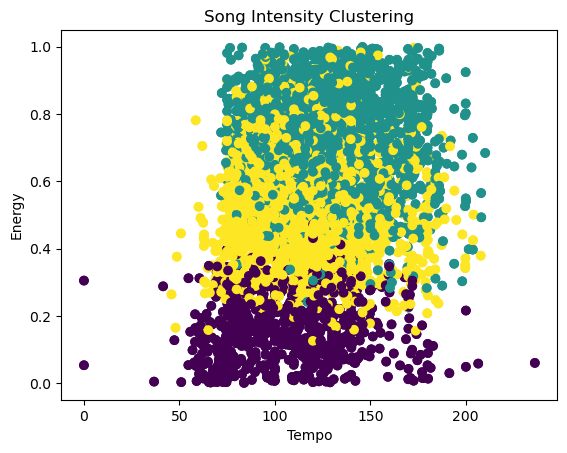

                       id    tempo  energy  loudness  valence  intensity
0  7dTxqsaFGHOXwtzHINjfHv  162.139   0.799    -4.939    0.577          1
1  14Qcrx6Dfjvcj0H8oV8oUW  112.241   0.130   -17.719    0.122          0
2  7K9Z3yFNNLv5kwTjQYGjnu  132.012   0.814    -3.788    0.509          1
3  3koAwrM1RO0TGMeQJ3qt9J  120.969   0.596    -9.804    0.896          1
4  4ByEFOBuLXpCqvO1kw8Wdm  124.945   0.726   -11.402    0.507          1


In [93]:
# prepare data for clustering (use features only)
X = df_filtered[['tempo', 'energy', 'loudness', 'valence']]

# standardize the data 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# apply KMeans clustering (use 3 clusters for low, mid, high intensity)
kmeans = KMeans(n_clusters=3, random_state=42)
df_filtered['intensity'] = kmeans.fit_predict(X_scaled)

# visualize the clusters 
plt.scatter(df_filtered['tempo'], df_filtered['energy'], c=df_filtered['intensity'], cmap='viridis')
plt.xlabel('Tempo')
plt.ylabel('Energy')
plt.title('Song Intensity Clustering')
plt.show()

print(df_filtered.head())

Remove the 'intensity' and 'id' columns. 

Standardize the remaining features, and then split the dataset into training and test sets with 80% for training and 20% for testing.

In [94]:
X = df_filtered.drop(['intensity', 'id'], axis=1).values
y = df_filtered['intensity'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)



Build a neural network with one hidden layer that uses ReLU activation for the hidden layer and softmax for the output layer. 

Initialize the weights with He initialization, compute forward and backward passes, and update the weights using gradient descent. 

After training, evaluate the model's accuracy on the test data and output the classification.

In [95]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # initialize weights and biases with He initialization for ReLU activation
        self.W1 = np.random.randn(self.input_size, self.hidden_size) * np.sqrt(2. / self.input_size)
        self.b1 = np.zeros((1, self.hidden_size))
        self.W2 = np.random.randn(self.hidden_size, self.output_size) * np.sqrt(2. / self.hidden_size)
        self.b2 = np.zeros((1, self.output_size))
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)
    
    def softmax(self, x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / e_x.sum(axis=1, keepdims=True)
    
    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.softmax(self.z2)
        return self.a2
        
    def backward(self, X, y, output, learning_rate):
        # compute loss (cross-entropy)
        error = output - y
        d_W2 = np.dot(self.a1.T, error)
        d_b2 = np.sum(error, axis=0, keepdims=True)
        
        d_a1 = np.dot(error, self.W2.T)
        d_z1 = d_a1 * self.relu_derivative(self.a1)
        d_W1 = np.dot(X.T, d_z1)
        d_b1 = np.sum(d_z1, axis=0, keepdims=True)
        
        # update weights and biases
        self.W2 -= learning_rate * d_W2
        self.b2 -= learning_rate * d_b2
        self.W1 -= learning_rate * d_W1
        self.b1 -= learning_rate * d_b1
    
    def train(self, X, y, learning_rate, epochs):
        # one-hot encode the labels y
        y_one_hot = np.eye(self.output_size)[y]
        
        for epoch in range(epochs):
            # forward pass
            output = self.forward(X)
            
            # compute loss (cross-entropy)
            loss = -np.mean(np.sum(y_one_hot * np.log(output + 1e-10), axis=1))  # Cross-entropy loss
            print(f"Epoch {epoch}/{epochs}, Loss: {loss}")
            
            # backward pass
            self.backward(X, y_one_hot, output, learning_rate)
    
    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)

learning_rate = 0.0001 
epochs = 1000
nn = NeuralNetwork(input_size=X_train.shape[1], hidden_size=64, output_size=len(np.unique(y_train)))
nn.train(X_train, y_train, learning_rate, epochs)

# evaluate on test data
predictions = nn.predict(X_test)
accuracy = np.mean(predictions == y_test) * 100  
print(f"Accuracy on test data: {accuracy:.2f}%")

Epoch 0/1000, Loss: 2.8448414896632723
Epoch 1/1000, Loss: 0.5011704518698594
Epoch 2/1000, Loss: 0.4163879699172821
Epoch 3/1000, Loss: 1.0461058519097282
Epoch 4/1000, Loss: 0.25673636945786066
Epoch 5/1000, Loss: 0.2103903119999918
Epoch 6/1000, Loss: 0.1756153275435179
Epoch 7/1000, Loss: 0.16594774957806782
Epoch 8/1000, Loss: 0.15711384151302826
Epoch 9/1000, Loss: 0.15228075233294242
Epoch 10/1000, Loss: 0.14827691299147394
Epoch 11/1000, Loss: 0.14505784355139792
Epoch 12/1000, Loss: 0.142172327259268
Epoch 13/1000, Loss: 0.13953009450905962
Epoch 14/1000, Loss: 0.13704957683036945
Epoch 15/1000, Loss: 0.13469967513346906
Epoch 16/1000, Loss: 0.1324549759017001
Epoch 17/1000, Loss: 0.13029978815789003
Epoch 18/1000, Loss: 0.1282206345816051
Epoch 19/1000, Loss: 0.12622192365997764
Epoch 20/1000, Loss: 0.12429561119064898
Epoch 21/1000, Loss: 0.1224402478072166
Epoch 22/1000, Loss: 0.12065323369140683
Epoch 23/1000, Loss: 0.11893112241361355
Epoch 24/1000, Loss: 0.11726698232157

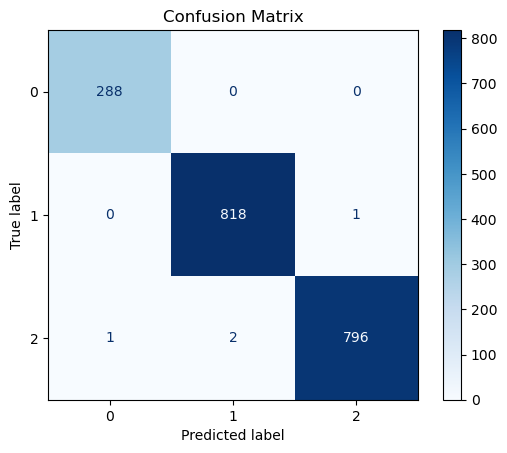

In [96]:
y_pred = nn.predict(X_test)

# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()